In [1]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Read data
data = pd.read_csv("netflix_titles.csv")

# Clean and pre-process data
# 1. Handle missing values (consider dropping rows or imputation techniques)
data.dropna(subset=["listed_in"], inplace=True)  # Drop rows with missing genre data

# 2. Convert release_year to numeric
data["release_year"] = pd.to_numeric(data["release_year"], errors="coerce")  # Handle non-numeric values

# 3. Encode categorical variables (listed_in)
le = LabelEncoder()
data["listed_in_encoded"] = le.fit_transform(data["listed_in"].str.split(",").str.join("|"))  # Combine genres into single string

# 4. Feature selection (consider including additional features like rating or duration)
features = ["release_year", "listed_in_encoded"]
X = data[features]

# K-Means Clustering for Demand Forecasting 
# You can explore other models like Time Series or Collaborative Filtering
kmeans = KMeans(n_clusters=5)  # Adjust number of clusters (k) based on analysis
kmeans.fit(X)

# Assign cluster labels to data
data["cluster_label"] = kmeans.labels_

# Analyze clusters and forecast demand (further steps needed)
# - Analyze the content within each cluster (listed_in, potentially description)
# - Identify trends within clusters over time (requires viewership data)
# - Use cluster insights to inform content acquisition strategies for different demand segments

data.head()  # Display the first few rows of the cleaned data


/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,listed_in_encoded,cluster_label
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,110,0
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,420,2
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",381,2
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,381,2
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,167,3


In [2]:
# Analyze cluster content
for cluster_label in data["cluster_label"].unique():
  cluster_data = data[data["cluster_label"] == cluster_label]
  
  # Analyze listed_in genres
  listed_in_counts = cluster_data["listed_in"].value_counts()
  print(f"\nCluster {cluster_label} - Listed In:")
  print(listed_in_counts.nlargest(10))  # Show top 10 most frequent genres
  
  # Sample descriptions (optional)
  descriptions = cluster_data["description"].sample(5)  # Sample 5 descriptions
  print(f"\nCluster {cluster_label} - Sample Descriptions:")
  for description in descriptions:
      print(description)


Cluster 0 - Listed In:
Children & Family Movies, Comedies                          129
Children & Family Movies                                    120
Anime Series, International TV Shows                         62
British TV Shows, Docuseries, International TV Shows         27
British TV Shows, Docuseries, Science & Nature TV            25
British TV Shows, International TV Shows, Reality TV         21
British TV Shows, Crime TV Shows, International TV Shows     20
Anime Series, Kids' TV                                       17
Children & Family Movies, Dramas                             16
British TV Shows, Crime TV Shows, Docuseries                 16
Name: listed_in, dtype: int64

Cluster 0 - Sample Descriptions:
Witness the wonders of human gestation through cutting-edge CGI, and learn how those nine months inside the womb can affect all aspects of one's life.
This sequel to the award-winning nature series "Blue Planet" dives beneath Earth's oceans to reveal the dazzling vistas a

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Preprocess descriptions (optional but recommended)
def preprocess_text(text):
  # Lowercase text
  text = text.lower()
  # Remove punctuation
  text = "".join([char for char in text if char.isalnum() or char.isspace()])
  # Remove stop words (optional)
  # from nltk.corpus import stopwords  # Uncomment if using stopwords
  # stop_words = stopwords.words("english")
  # text = " ".join([word for word in text.split() if word not in stop_words])
  return text

# Apply preprocessing (if desired)
data["description"] = data["description"].apply(preprocess_text)

# Prepare descriptions for TF-IDF
descriptions = data["description"].tolist()

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100)  # Adjust number of features

# Fit the vectorizer on the descriptions
tfidf_matrix = vectorizer.fit_transform(descriptions)

# Analyze TF-IDF for each cluster
for cluster_label in data["cluster_label"].unique():
  cluster_data = data[data["cluster_label"] == cluster_label]
  cluster_descriptions = cluster_data["description"].tolist()
  cluster_tfidf = tfidf_matrix[cluster_data.index]
  
  # Get top features (keywords) for this cluster
  top_features_indices = cluster_tfidf.sum(axis=0).argsort()[-10:]  # Get top 10 indices
  top_features = vectorizer.get_feature_names_out()[top_features_indices]
  print(f"\nCluster {cluster_label} - Top Keywords:")
  for feature in top_features:
      print(feature)


Cluster 0 - Top Keywords:
['standup' 'comedy' 'death' 'son' 'man' 'woman' 'murder' 'past' 'down'
 'daughter' 'special' 'love' 'mother' 'becomes' 'against' 'years'
 'documentary' 'true' 'father' 'over' 'between' 'four' 'lives' 'hes'
 'more' 'finds' 'group' 'show' 'takes' 'have' 'one' 'city' 'own' 'through'
 'war' 'girl' 'other' 'teen' 'while' 'all' 'three' 'can' 'home' 'them'
 'find' 'has' 'mysterious' 'about' 'she' 'back' 'be' 'team' 'two' 'it'
 'take' 'out' 'high' 'must' 'help' 'its' 'where' 'get' 'life' 'family'
 'him' 'friends' 'they' 'save' 'are' 'school' 'but' 'young' 'who' 'he'
 'up' 'that' 'new' 'after' 'series' 'into' 'at' 'by' 'world' 'as' 'is'
 'from' 'for' 'an' 'this' 'her' 'when' 'on' 'with' 'their' 'his' 'in' 'of'
 'to' 'and' 'the']

Cluster 2 - Top Keywords:
['documentary' 'murder' 'war' 'mother' 'girl' 'hes' 'father' 'death'
 'daughter' 'teen' 'son' 'becomes' 'team' 'between' 'past' 'over' 'true'
 'save' 'get' 'down' 'city' 'against' 'four' 'have' 'high' 'can' 'own'
 'm

In [4]:
# Top genres within the cluster (using listed_in for illustration)
top_genres = cluster_data["listed_in"].value_counts().nlargest(5)
  
  # Print insights for this cluster
print(f"\nCluster {cluster_label}:")
print("Top Genres:", top_genres)
  
  # Prioritize acquisitions based on theme and external indicators (replace with your logic)
  # Consider incorporating insights from external research, user data (if available), 
  # and A/B testing results to refine content acquisition decisions.
print("Prioritize acquiring content considering top genres and external demand indicators.")



Cluster 4:
Top Genres: Action & Adventure, Dramas, International Movies      103
Action & Adventure, International Movies               75
Action & Adventure                                     68
Action & Adventure, Comedies, International Movies     57
Action & Adventure, Sci-Fi & Fantasy                   49
Name: listed_in, dtype: int64
Prioritize acquiring content considering top genres and external demand indicators.


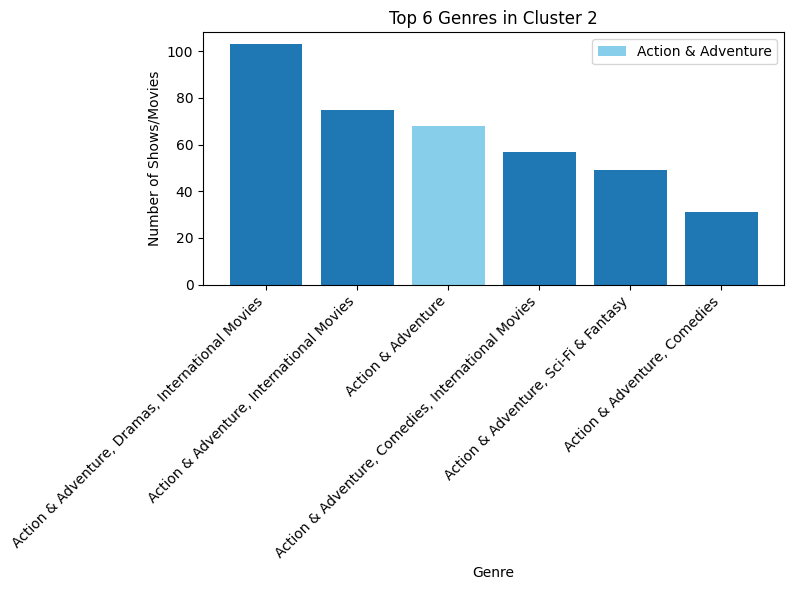

In [5]:
# Filter data for Cluster 4
cluster_2_data = cluster_data[cluster_data["cluster_label"] == 4]

# Genre counts within Cluster 4
genre_counts = cluster_2_data["listed_in"].value_counts().nlargest(6)  # Get top 6

# Prepare data for visualization
genres = genre_counts.index.tolist()
counts = genre_counts.tolist()

# Create bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.bar(genres, counts)
plt.xlabel("Genre")
plt.ylabel("Number of Shows/Movies")
plt.title("Top 6 Genres in Cluster 2")

# Highlight Action & Adventure bar (if it's among top 6)
if "Action & Adventure" in genres:
  action_index = genres.index("Action & Adventure")
  plt.bar(action_index, counts[action_index], color='skyblue', label='Action & Adventure')
plt.legend()

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()

# Save or display the chart
# plt.savefig("cluster_2_top_6_genres.png")  # Uncomment to save the chart as an image
plt.show()

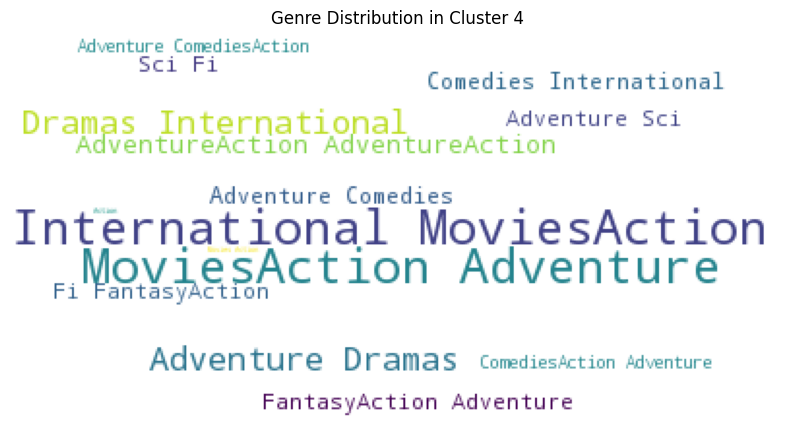

In [6]:
from wordcloud import WordCloud

# Import libraries (assuming you have wordcloud installed)

# Prepare genre counts data (similar to previous visualizations)

# Create the word cloud object with font size and color options based on genre counts
wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    relative_scaling=0.6  # Optional: Specify a custom font (replace with path)
).generate(" ".join(genre_counts.index * genre_counts.values))  # Repeat genres based on counts

# Color function based on genre counts (replace with your logic)
def color_func(word, font_size, position, random_state=None):
  count = genre_counts.get(word, 0)  # Get count for the genre
  color = 'black'  # Default color
  if count > 10:  # Adjust threshold for prominent genres (replace with your criteria)
    color = 'red'  # Example color for prominent genres
  return color



# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Genre Distribution in Cluster 4")
plt.show()


In [7]:
%pip install pycountry

In [28]:
%pip install seaborn

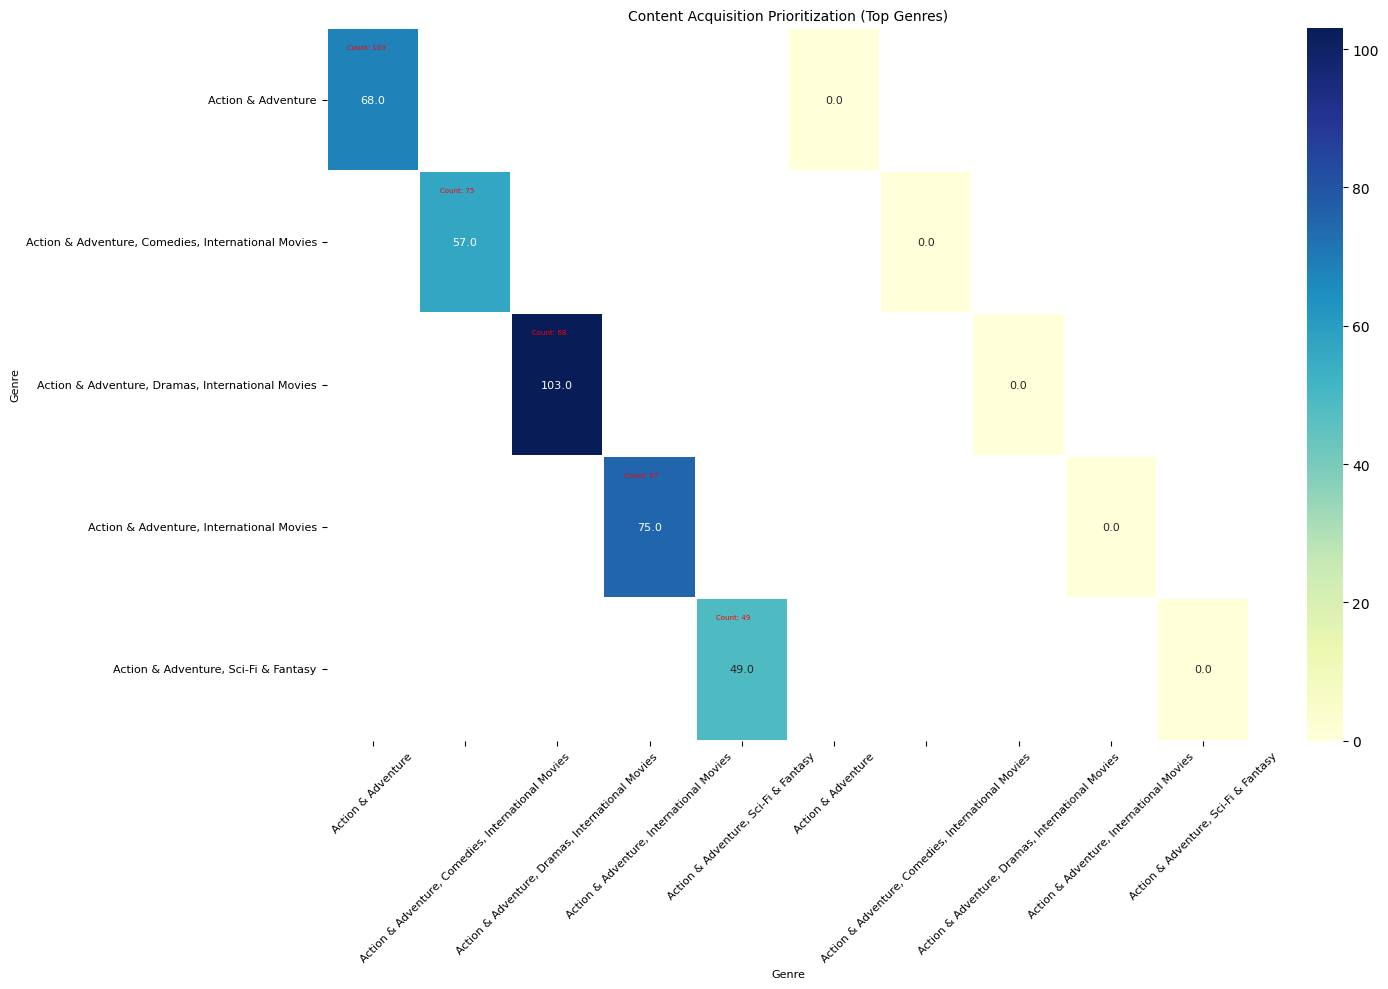

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define top genres and counts (replace with your actual data)
top_genres = [
    "Action & Adventure, Dramas, International Movies",
    "Action & Adventure, International Movies",
    "Action & Adventure",
    "Action & Adventure, Comedies, International Movies",
    "Action & Adventure, Sci-Fi & Fantasy",
]
genre_counts = [103, 75, 68, 57, 49]

# Create a dummy DataFrame (modify as needed)
data = {'genre': top_genres, 'count': genre_counts, 'rating': [0 for _ in genre_counts]}  # Assuming initial rating = 0
df = pd.DataFrame(data)

# Reduce data points (consider filtering or grouping genres)
# This is an example, adjust based on your needs
filtered_df = df.iloc[:6]  # Show only the top 3 genres

# Pivot table for heatmap
pivot_table = filtered_df.pivot_table(values='rating', index='genre', columns='genre', aggfunc='mean')  # Assuming square heatmap

# Create the heatmap with increased font size and spacing
plt.figure(figsize=(15, 10))  # Adjust figure size for better readability
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.2, annot_kws={"fontsize": 8})  # Increase annotation font size
plt.tick_params(labelsize=8)  # Increase axis tick label size
plt.title('Content Acquisition Prioritization (Top Genres)', fontsize=10)  # Increase title font size
plt.xlabel('Genre', fontsize=8)
plt.ylabel('Genre', fontsize=8)
plt.xticks(rotation=45)  # Rotate genre names if needed

# Add comments or markers to indicate content diversity (example)
for idx, row in filtered_df.iterrows():
  comment = f"Count: {row['count']}"  # Example comment based on count
  plt.annotate(comment, (idx, idx), xytext=(15, -15), textcoords='offset points', fontsize=5, color='red')

plt.tight_layout()
plt.show()
